In [1]:
import torch
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics.functional import multiclass_accuracy
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd

C:\Users\Ilin\anaconda3\envs\pytorch_testing\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


The goal of this notebook project is to explore some basic concepts of building good quality neural models with Pytorch. A classic testcase is to use the MNIST dataset, however here I have opted for an additional challenge of trying these concepts out with a different but similar dataset. This dataset contains images of hand written arabic characters and their respective labels. This is a bit more challenging since we have 28 different possible labels rather than the traditional 10 of the MNIST dataset. While the dataset also contains .csv files where the data is given in a much more convenient format, using the actuall image data provides sligthly more of a challenge so let's go with that instead.   

Setting up file paths and some other things for converting image data to tensors.

In [2]:
training_path ='./archive/Train Images 13440x32x32/train/'
test_path ='./archive/Test Images 3360x32x32/test/'


train_files=os.listdir(training_path)
test_files=os.listdir(test_path)
transform=transforms.Compose([transforms.ToTensor()])


In [3]:
def data_builder(path, files):
    '''Function for converting image data to tensors for using in training, along with getting the labels
       from the file name.
    '''
    img_fordim=cv2.imread(os.path.join(path,files[0]), 0)
    image_size=torch.flatten(transform(img_fordim))
    dim1=image_size.shape[0]
    dim0=len(files)
    data=torch.zeros((dim0, dim1))
    labels=torch.zeros((dim0, 1))
    for i, file in enumerate(files):
        img=cv2.imread(os.path.join(path,file), 0)
        flat_tens=torch.flatten(transform(img))
        data[i]=flat_tens
        label=file.split('_')[-1][:2]
        labels[i]=float(label)-1
        
    return data, labels

In [4]:
device= 'cuda' if torch.cuda.is_available() else "cpu"

device

'cpu'

In [5]:
test_data, test_labels = data_builder(test_path, test_files)

train_data, train_labels = data_builder(training_path, train_files)


Naturally we don't neccessarilly want to have to remake the tensors with the data each and every time we have to restart the notebook, so the code block bellow contains code for saving and opening the tensors with the data as seperate files.

In [5]:
#torch.save(test_data, 'test_data.pt')
#torch.save(test_labels, 'test_labels.pt')
#torch.save(train_data, 'train_data.pt')
#torch.save(train_labels, 'train_labels.pt')

test_data= torch.load('test_data.pt')
test_labels= torch.load('test_labels.pt')
train_data= torch.load('train_data.pt')
train_labels= torch.load('train_labels.pt')

This is an initial model to test various aspects of Pytorch model bulding.

In [6]:
class ArabicCharClassifier(nn.Module):
    def __init__(self, n_char):
        super().__init__()
        self.hidden1=nn.Linear(1024, 100)
        self.hidden2=nn.Linear(100, 100)
        self.hidden3=nn.Linear(100,100)
        self.hidden4=nn.Linear(100,100)
        self.hidden5=nn.Linear(100,100)
        self.hiddenfin=nn.Linear(100, n_char)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout()
        self.batch1=nn.BatchNorm1d(100)
        self.batch2=nn.BatchNorm1d(100)
        self.batch3=nn.BatchNorm1d(100)
        self.batch4=nn.BatchNorm1d(100)
        self.batch5=nn.BatchNorm1d(100)
        
    def forward(self, x):
        X = self.hidden1(x)
        X = self.relu(X)
        X = self.batch1(X)
        X = self.dropout(X)
        
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.batch2(X)
        X = self.dropout(X)
        
        X = self.hidden3(X)
        X = self.relu(X)
        X = self.batch3(X)
        X = self.dropout(X)
        
        X = self.hidden4(X)
        X = self.relu(X)
        X = self.batch4(X)
        X = self.dropout(X)
        
        X = self.hidden5(X)
        X = self.relu(X)
        X = self.batch5(X)
        X = self.dropout(X)
        
        
        
        X = self.hiddenfin(X)
        
        return X
    

In [7]:
model=ArabicCharClassifier(n_char=28).to(device)
model

ArabicCharClassifier(
  (hidden1): Linear(in_features=1024, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (hidden4): Linear(in_features=100, out_features=100, bias=True)
  (hidden5): Linear(in_features=100, out_features=100, bias=True)
  (hiddenfin): Linear(in_features=100, out_features=28, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
loss = nn.CrossEntropyLoss()

optimization = optim.Adam(params=model.parameters(), lr=0.001)

In [9]:
def metrics(y_pred, y_true, num_char):
    acc = multiclass_accuracy(y_pred, y_true)
    f1_score = multiclass_f1_score(y_pred, y_true, num_classes=num_char)
    return f1_score, acc 

In [10]:
num_epoch = 100

train_data, train_labels = train_data.to(device), train_labels.to(device)

test_data, test_labels = test_data.to(device), test_labels.to(device)

train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

for epoch in range(num_epoch):
    
    train_pred=model(train_data)
    model.train()
    
    
    
    y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
    
    optimization.zero_grad()
    
    loss_epoch = loss(train_pred, y_train)
    
    f1_train, acc_train = metrics(train_pred, y_train, 28)
    
    loss_epoch.backward()
    
    optimization.step()
    
    train_metrics['loss'].append(loss_epoch.item())
    train_metrics['accuracy'].append(acc_train.item()*100)
    train_metrics['f1_score'].append(f1_train.item())
    
    model.eval()
    with torch.inference_mode():
        test_pred = model(test_data)
        y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
        loss_eval=loss(test_pred, y_eval)
        f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
        
        test_metrics['accuracy'].append(acc_test.item()*100)
        test_metrics['f1_score'].append(f1_test.item())
        test_metrics['loss'].append(loss_eval.item())
        
        
    if epoch%10==0:
        print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
        
        
    

Epoch: 0 | Train loss: 3.62446 | Train accuracy: 3.743% | Train f1 0.037 | Test accuracy 3.542% | Test f1 0.035
Epoch: 10 | Train loss: 3.33119 | Train accuracy: 3.690% | Train f1 0.037 | Test accuracy 3.839% | Test f1 0.038
Epoch: 20 | Train loss: 3.32454 | Train accuracy: 9.204% | Train f1 0.092 | Test accuracy 9.673% | Test f1 0.097
Epoch: 30 | Train loss: 3.29083 | Train accuracy: 11.555% | Train f1 0.116 | Test accuracy 11.399% | Test f1 0.114
Epoch: 40 | Train loss: 3.04118 | Train accuracy: 10.751% | Train f1 0.108 | Test accuracy 10.655% | Test f1 0.107
Epoch: 50 | Train loss: 2.64389 | Train accuracy: 14.792% | Train f1 0.148 | Test accuracy 14.940% | Test f1 0.149
Epoch: 60 | Train loss: 2.41645 | Train accuracy: 21.890% | Train f1 0.219 | Test accuracy 21.964% | Test f1 0.220
Epoch: 70 | Train loss: 2.23788 | Train accuracy: 26.615% | Train f1 0.266 | Test accuracy 26.280% | Test f1 0.263
Epoch: 80 | Train loss: 2.08058 | Train accuracy: 30.885% | Train f1 0.309 | Test accur

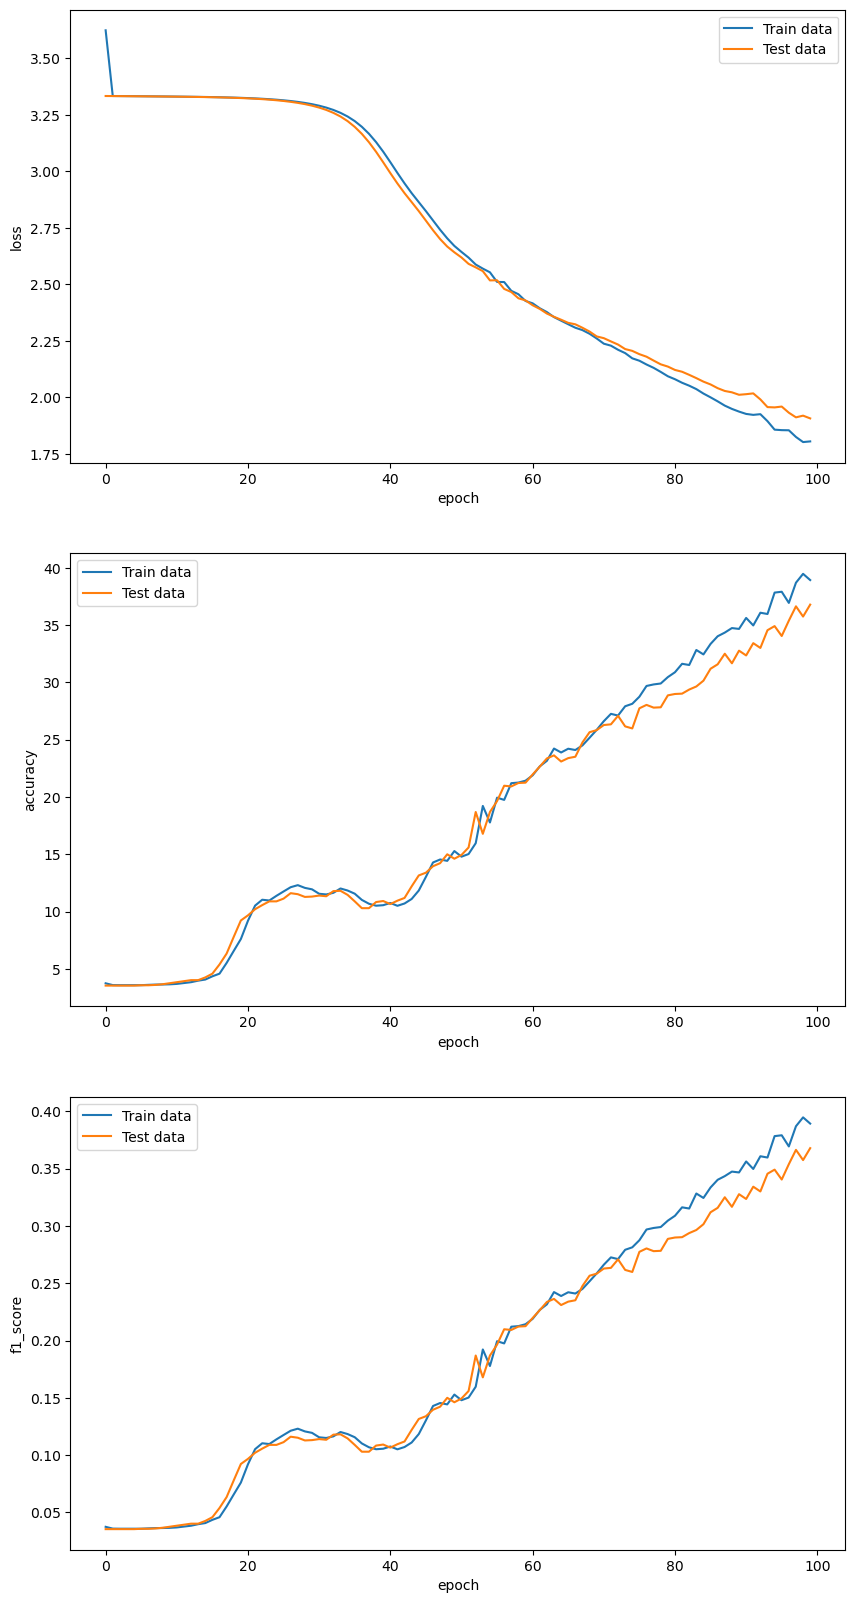

In [11]:
fig, axs = plt.subplots(3, figsize=(10,20))
sns.lineplot(data=train_metrics, x='epoch', y='loss', label='Train data', ax=axs[0])
sns.lineplot(data=test_metrics, x='epoch', y='loss', label='Test data', ax=axs[0])
sns.lineplot(data=train_metrics, x='epoch', y='accuracy', label='Train data', ax=axs[1])
sns.lineplot(data=test_metrics, x='epoch', y='accuracy', label='Test data', ax=axs[1])
sns.lineplot(data=train_metrics, x='epoch', y='f1_score', label='Train data', ax=axs[2])
sns.lineplot(data=test_metrics, x='epoch', y='f1_score', label='Test data', ax=axs[2])
plt.legend()

In [12]:
class ModularNN(nn.Module):
    def __init__(self, n_char, input_size, neurons, depth, add_Dropout=True):
        super().__init__()
        self.layers=nn.ModuleList()
        self.input_layer=nn.Linear(input_size, neurons)
        for i in range(depth):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(neurons))
            if add_Dropout:
                self.layers.append(nn.Dropout())
        self.final_layer=nn.Linear(neurons, n_char)

    def forward(self, X):
        x=self.input_layer(X)
        for layer in self.layers:
            x=layer(x)
        x=self.final_layer(x)
        
        return x
            

In [13]:
model_2=ModularNN(n_char=28, input_size=1024, neurons=100, depth=5).to(device)
model_2

ModularNN(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(100, eps=1e-05, momentum=0.1,

In [14]:
def SingleTrain(layer_size, depth, num_epochs, learning_rate, printing = False, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, loss=nn.CrossEntropyLoss()):
    model=model_2=ModularNN(n_char=28, input_size=1024, neurons=layer_size, depth=depth).to(device)
    loss=loss
    optimization= optim.Adam(params=model.parameters(), lr=learning_rate)

    train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    for epoch in range(num_epochs):
    
        train_pred=model(train_data)
        model.train()
        
        y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
        
        optimization.zero_grad()
        
        loss_epoch = loss(train_pred, y_train)
        
        f1_train, acc_train = metrics(train_pred, y_train, 28)
        
        loss_epoch.backward()
        
        optimization.step()
        
        train_metrics['loss'].append(loss_epoch.item())
        train_metrics['accuracy'].append(acc_train.item()*100)
        train_metrics['f1_score'].append(f1_train.item())
    
        model.eval()
        with torch.inference_mode():
            test_pred = model(test_data)
            y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
            loss_eval=loss(test_pred, y_eval)
            f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
            
            test_metrics['accuracy'].append(acc_test.item()*100)
            test_metrics['f1_score'].append(f1_test.item())
            test_metrics['loss'].append(loss_eval.item())

        if printing:
            if epoch%10==0:
                print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
            

    return train_metrics, test_metrics

    

Since there are quite a few possible parameter combinations to explore, I want to first narow down the range of parameters that I want to gather statistics for. In order to do this I am exploring the parameters in the standard way of randomly selecting the parameter for each training cycle. A quick visual inspection at this stage will tell us what parameter range to take a closer look at.

In [15]:
depths=[1,2,3,4, 5, 6, 7, 8, 9]
layer_sizes=[30, 40, 50, 60, 70, 80, 90, 100, 110]
#rates=[0.001, 0.0005, 0.0001]

ran_depths = random.choices(depths, k=10)
ran_sizes = random.choices(layer_sizes, k=10)

In [29]:
training_data=[]
testing_data=[]
parameters={'depth':[], 'size':[]}
k=0
for depth, size in zip(ran_depths, ran_sizes):
    print(depth, size)
    tr_metric, ts_metric = SingleTrain(layer_size=size, depth=depth, num_epochs=100, learning_rate=0.001, printing=True)
    training_data.append(tr_metric)
    testing_data.append(ts_metric)
    #parameters['rate'].append(rate) initially was looking into a range of learning rates, but very quickly found out that 0.001 is a good balance of speed and stability 
    parameters['depth'].append(depth)
    parameters['size'].append(size)
    k+=1
    print(f'{k} down, {10-k} to go')
    print('------------------------')

4 70
Epoch: 0 | Train loss: 3.67240 | Train accuracy: 3.646% | Train f1 0.036 | Test accuracy 3.244% | Test f1 0.032
Epoch: 10 | Train loss: 3.33032 | Train accuracy: 3.653% | Train f1 0.037 | Test accuracy 3.929% | Test f1 0.039
Epoch: 20 | Train loss: 3.31747 | Train accuracy: 8.504% | Train f1 0.085 | Test accuracy 9.315% | Test f1 0.093
Epoch: 30 | Train loss: 3.27022 | Train accuracy: 10.804% | Train f1 0.108 | Test accuracy 9.851% | Test f1 0.099
Epoch: 40 | Train loss: 3.03967 | Train accuracy: 9.137% | Train f1 0.091 | Test accuracy 9.256% | Test f1 0.093
Epoch: 50 | Train loss: 2.75305 | Train accuracy: 14.829% | Train f1 0.148 | Test accuracy 15.744% | Test f1 0.157
Epoch: 60 | Train loss: 2.53738 | Train accuracy: 20.595% | Train f1 0.206 | Test accuracy 19.970% | Test f1 0.200
Epoch: 70 | Train loss: 2.37349 | Train accuracy: 24.821% | Train f1 0.248 | Test accuracy 25.565% | Test f1 0.256
Epoch: 80 | Train loss: 2.22343 | Train accuracy: 29.985% | Train f1 0.300 | Test acc

These simple tests seem to indicate that a good number of layers is between 1 and 3, and a good neuron range seems to be 80-110 (if not immediatelly clear from a single run of the code I encourage trying 2-3 times and it should become clearer), so we can do even more tests in this narrower range, so that we can do some statistics.

In [26]:
depths_2=[1,2,3]
layer_sizes_2=[80, 90, 100, 110, 120, 130, 140]

ran_depths_2 = random.choices(depths_2, k=100)
ran_sizes_2 = random.choices(layer_sizes_2, k=100)

parameters={'loss_train':[], 'accuracy_train':[], 'f1_score_train':[],'loss_test':[], 'accuracy_test':[], 'f1_score_test':[], 'depth':[], 'size':[]}
k=0
for depth, size in zip(ran_depths_2, ran_sizes_2):
    print(depth, size)
    tr_metric, ts_metric = SingleTrain(layer_size=size, depth=depth, num_epochs=100, learning_rate=0.001, printing=False)
    parameters['loss_train'].append(tr_metric['loss'][-1])
    parameters['loss_test'].append(ts_metric['loss'][-1])
    parameters['accuracy_train'].append(tr_metric['accuracy'][-1])
    parameters['accuracy_test'].append(ts_metric['accuracy'][-1])
    parameters['f1_score_train'].append(tr_metric['f1_score'][-1])
    parameters['f1_score_test'].append(ts_metric['f1_score'][-1])
    parameters['depth'].append(depth)
    parameters['size'].append(size)
    k+=1
    print(f'{k} down, {100-k} to go')
    print('------------------------')

1 110
1 down, 99 to go
------------------------
2 90
2 down, 98 to go
------------------------
1 130
3 down, 97 to go
------------------------
2 140
4 down, 96 to go
------------------------
3 90
5 down, 95 to go
------------------------
3 110
6 down, 94 to go
------------------------
3 130
7 down, 93 to go
------------------------
1 130
8 down, 92 to go
------------------------
1 140
9 down, 91 to go
------------------------
2 110
10 down, 90 to go
------------------------
2 80
11 down, 89 to go
------------------------
3 80
12 down, 88 to go
------------------------
1 80
13 down, 87 to go
------------------------
2 90
14 down, 86 to go
------------------------
1 130
15 down, 85 to go
------------------------
2 130
16 down, 84 to go
------------------------
2 80
17 down, 83 to go
------------------------
3 140
18 down, 82 to go
------------------------
1 90
19 down, 81 to go
------------------------
2 80
20 down, 80 to go
------------------------
3 90
21 down, 79 to go
---------------

Since I am not dealing with a lot of data points, visualizing the results is a bit noisy, so a simple table would actually be a better choice. Regardless this helps narrow down what hyperparameter range we need to look at. One could say this is somewhat overkill, since I managed to find a good value for probably the most important parameter (learning rate) rather quickly, and now we could just increase the number of epochs, and get the result that way. But it's always good develop a model, which will require a minimal number of epochs, since that can speed up retraining if needed, and also if additional data is ever introduced, having a model that trains as efficiently as possible is always beneficial. Further more, in theory deeper and bigger models will almost always produce better results, if enough data is available to avoid overfitting. But since we're dealing with a fixed dataset (though synthesising new data is always possible from existing data, but we're trying to keep things simple), we want to develop a model which can efficiently produce a reasonable results with the available data.

In [27]:
parameters_df=pd.DataFrame(parameters)
grouped=parameters_df.groupby(['depth', 'size']).mean()

grouped

loss_train  accuracy_train  f1_score_train  loss_test  \
depth size                                                          
1     80      1.713008       51.831846        0.518318   1.802353   
      90      1.651240       53.670633        0.536706   1.742775   
      100     1.565843       55.783730        0.557837   1.665348   
      110     1.520793       56.609003        0.566090   1.626778   
      120     1.478554       57.857141        0.578571   1.596125   
      130     1.427315       59.325396        0.593254   1.540667   
      140     1.380409       60.624999        0.606250   1.509745   
2     80      1.528916       54.701451        0.547015   1.597025   
      90      1.420249       57.348401        0.573484   1.502172   
      100     1.339303       59.627977        0.596280   1.430699   
      110     1.262838       61.718750        0.617188   1.368352   
      120     1.196852       63.716519        0.637165   1.311917   
      130     1.167203       64.346301        0.643463   1.298827   
      140     1.104501       66.014031        0.660140   1.237867   
3     80      1.579390       51.143353        0.511434   1.640107   
      90      1.498795       53.503639        0.535036   1.565714   
      100     1.421589       55.451391        0.554514   1.504344   
      110     1.365904       57.157737        0.571577   1.444664   
      120     1.348036       57.602306        0.576023   1.438153   
      130     1.259434       59.832589        0.598326   1.361953   
      140     1.183805       61.949405        0.619494   1.298999   

            accuracy_test  f1_score_test  
depth size                                
1     80        47.791666       0.477917  
      90        49.265873       0.492659  
      100       51.443453       0.514435  
      110       51.979166       0.519792  
      120       53.050596       0.530506  
      130       54.399800       0.543998  
      140       55.238098       0.552381  
2     80        52.012648       0.520126  
      90        54.029017       0.540290  
      100       55.654761       0.556548  
      110       57.410713       0.574107  
      120       59.107143       0.591071  
      130       59.387754       0.593878  
      140       60.918367       0.609184  
3     80        49.062500       0.490625  
      90        51.216931       0.512169  
      100       52.708334       0.527083  
      110       54.352678       0.543527  
      120       54.374999       0.543750  
      130       56.197917       0.561979  
      140       57.857142       0.578571

Looking at the result it's at least clear that 2 layers is the way to go, keeping in mind that this means 4 hidden layers total, including the output layer and the input layer. Given that it also seems that the model favours large amounts of neurons, we must be carefull to avoid overfitting, as that would cause more headaches since we would need more data. However knowing a rough area for playing with the overall architecture of the model is a good jumping off point for more fine tunning.

In [30]:
layer_sizes_2=[110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


parameters_2={'loss_train':[], 'accuracy_train':[], 'f1_score_train':[],'loss_test':[], 'accuracy_test':[], 'f1_score_test':[], 'variance_check':[],'size':[]}
k=0
for size in layer_sizes_2:
    tr_metric, ts_metric = SingleTrain(layer_size=size, depth=2, num_epochs=200, learning_rate=0.001, printing=True)
    parameters_2['loss_train'].append(tr_metric['loss'][-1])
    parameters_2['loss_test'].append(ts_metric['loss'][-1])
    parameters_2['accuracy_train'].append(tr_metric['accuracy'][-1])
    parameters_2['accuracy_test'].append(ts_metric['accuracy'][-1])
    parameters_2['f1_score_train'].append(tr_metric['f1_score'][-1])
    parameters_2['f1_score_test'].append(ts_metric['f1_score'][-1])
    parameters_2['variance_check'].append(tr_metric['accuracy'][-1]-ts_metric['accuracy'][-1])
    parameters_2['size'].append(size)
    k+=1
    print(f'{k} down, {len(layer_sizes_2)-k} to go')
    print('------------------------')

Epoch: 0 | Train loss: 3.65952 | Train accuracy: 3.237% | Train f1 0.032 | Test accuracy 4.196% | Test f1 0.042
Epoch: 10 | Train loss: 3.26845 | Train accuracy: 12.031% | Train f1 0.120 | Test accuracy 11.935% | Test f1 0.119
Epoch: 20 | Train loss: 3.02180 | Train accuracy: 15.357% | Train f1 0.154 | Test accuracy 15.506% | Test f1 0.155
Epoch: 30 | Train loss: 2.62172 | Train accuracy: 22.307% | Train f1 0.223 | Test accuracy 22.798% | Test f1 0.228
Epoch: 40 | Train loss: 2.32616 | Train accuracy: 31.615% | Train f1 0.316 | Test accuracy 32.292% | Test f1 0.323
Epoch: 50 | Train loss: 2.13015 | Train accuracy: 38.207% | Train f1 0.382 | Test accuracy 37.173% | Test f1 0.372
Epoch: 60 | Train loss: 1.96442 | Train accuracy: 42.850% | Train f1 0.428 | Test accuracy 41.726% | Test f1 0.417
Epoch: 70 | Train loss: 1.79044 | Train accuracy: 48.021% | Train f1 0.480 | Test accuracy 45.744% | Test f1 0.457
Epoch: 80 | Train loss: 1.60035 | Train accuracy: 52.932% | Train f1 0.529 | Test a

In [31]:
parameters_layer=pd.DataFrame(parameters_2)
parameters_layer

,loss_train,accuracy_train,f1_score_train,loss_test,accuracy_test,f1_score_test,variance_check,size
0,0.450455,86.175597,0.861756,0.936069,71.369046,0.713690,0.148066,110
1,0.494317,85.193455,0.851935,0.960649,70.654762,0.706548,0.145387,120
2,0.430709,87.046129,0.870461,0.931809,71.041667,0.710417,0.160045,130
3,0.414896,87.663692,0.876637,0.919671,71.577382,0.715774,0.160863,140
4,0.390486,88.340771,0.883408,0.904446,72.113097,0.721131,0.162277,150
5,0.378702,88.898808,0.888988,0.932353,72.351193,0.723512,0.165476,160
6,0.363621,89.389879,0.893899,0.905567,72.113097,0.721131,0.172768,170
7,0.353388,89.568454,0.895685,0.908956,73.273808,0.732738,0.162946,180
8,0.311376,91.227680,0.912277,0.879120,74.255955,0.742560,0.169717,190
9,0.337385,89.866072,0.898661,0.892732,73.363096,0.733631,0.165030,200


As can be clearly seen, while the performance might be increasing, the difference in the f1 scores between the training and test set seems to suggest, that overfitting starts to become a greater concern for higher node numbers. Therefore, I'll go with a model with 2 inner hidden layers (so 3 total) and 160 nodes per inner layer. Since the results gave us a rather shallow network, this result might change for the final layer, since we will test how the size of the final layer affects the result, which we will investigate next.

In [16]:
class TestingTails(nn.Module):
    def __init__(self, n_char, nodes_inner, nodes_outer):
        super().__init__()
        self.inner=nn.Linear(1024, nodes_inner)
        self.hidden1=nn.Linear(nodes_inner, 160)
        self.hidden2=nn.Linear(160,nodes_outer)
        self.outer=nn.Linear(nodes_outer, n_char)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout()
        self.batch1=nn.BatchNorm1d(nodes_inner)
        self.batch2=nn.BatchNorm1d(160)
        self.batch3=nn.BatchNorm1d(nodes_outer)
        
    def forward(self, x):
        X = self.inner(x)
        X = self.relu(X)
        X = self.batch1(X)
        X = self.dropout(X)
        
        X = self.hidden1(X)
        X = self.relu(X)
        X = self.batch2(X)
        X = self.dropout(X)
        
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.batch3(X)
        X = self.dropout(X)
        
        
        X = self.outer(X)
        
        return X

In [17]:
model_3=TestingTails(n_char=28, nodes_inner=10, nodes_outer=160).to(device)
model_3

TestingTails(
  (inner): Linear(in_features=1024, out_features=10, bias=True)
  (hidden1): Linear(in_features=10, out_features=160, bias=True)
  (hidden2): Linear(in_features=160, out_features=160, bias=True)
  (outer): Linear(in_features=160, out_features=28, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [18]:
def SingleTrain_tails(nodes_inner, nodes_outer, num_epochs, learning_rate,printing = False, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, loss=nn.CrossEntropyLoss()):
    model=model_2=TestingTails(n_char=28, nodes_inner=nodes_inner, nodes_outer=nodes_outer).to(device)
    loss=loss
    optimization= optim.Adam(params=model.parameters(), lr=learning_rate)

    train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    for epoch in range(num_epochs):
    
        train_pred=model(train_data)
        model.train()
        
        y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
        
        optimization.zero_grad()
        
        loss_epoch = loss(train_pred, y_train)
        
        f1_train, acc_train = metrics(train_pred, y_train, 28)
        
        loss_epoch.backward()
        
        optimization.step()
        
        train_metrics['loss'].append(loss_epoch.item())
        train_metrics['accuracy'].append(acc_train.item()*100)
        train_metrics['f1_score'].append(f1_train.item())
    
        model.eval()
        with torch.inference_mode():
            test_pred = model(test_data)
            y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
            loss_eval=loss(test_pred, y_eval)
            f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
            
            test_metrics['accuracy'].append(acc_test.item()*100)
            test_metrics['f1_score'].append(f1_test.item())
            test_metrics['loss'].append(loss_eval.item())

        if printing:
            if epoch%10==0:
                print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
            

    return train_metrics, test_metrics

    

In [19]:
tr, ts = SingleTrain_tails(nodes_inner=40, nodes_outer=160, num_epochs=100, learning_rate = 0.001,printing = True)

Epoch: 0 | Train loss: 3.64819 | Train accuracy: 3.624% | Train f1 0.036 | Test accuracy 3.720% | Test f1 0.037
Epoch: 10 | Train loss: 3.30349 | Train accuracy: 5.521% | Train f1 0.055 | Test accuracy 5.863% | Test f1 0.059
Epoch: 20 | Train loss: 3.16840 | Train accuracy: 9.010% | Train f1 0.090 | Test accuracy 9.435% | Test f1 0.094
Epoch: 30 | Train loss: 2.84542 | Train accuracy: 14.725% | Train f1 0.147 | Test accuracy 16.280% | Test f1 0.163
Epoch: 40 | Train loss: 2.45138 | Train accuracy: 29.829% | Train f1 0.298 | Test accuracy 28.810% | Test f1 0.288
Epoch: 50 | Train loss: 2.14234 | Train accuracy: 37.016% | Train f1 0.370 | Test accuracy 35.387% | Test f1 0.354
Epoch: 60 | Train loss: 1.89744 | Train accuracy: 43.929% | Train f1 0.439 | Test accuracy 42.411% | Test f1 0.424
Epoch: 70 | Train loss: 1.67490 | Train accuracy: 49.792% | Train f1 0.498 | Test accuracy 48.155% | Test f1 0.482
Epoch: 80 | Train loss: 1.47785 | Train accuracy: 54.955% | Train f1 0.550 | Test accur

In [34]:
layer_size=[x for x in range(10, 170, 10)]


parameters_3={'loss_train':[], 'accuracy_train':[], 'f1_score_train':[],'loss_test':[], 'accuracy_test':[], 'f1_score_test':[], 'variance_check':[],'first_layer':[]}
k=0
for layer in layer_size:
    print(layer)
    tr_metric, ts_metric = SingleTrain_tails(nodes_inner=layer, nodes_outer=160, num_epochs=100, learning_rate = 0.001,printing = True)
    parameters_3['loss_train'].append(tr_metric['loss'][-1])
    parameters_3['loss_test'].append(ts_metric['loss'][-1])
    parameters_3['accuracy_train'].append(tr_metric['accuracy'][-1])
    parameters_3['accuracy_test'].append(ts_metric['accuracy'][-1])
    parameters_3['f1_score_train'].append(tr_metric['f1_score'][-1])
    parameters_3['f1_score_test'].append(ts_metric['f1_score'][-1])
    parameters_3['variance_check'].append(tr_metric['accuracy'][-1]-ts_metric['accuracy'][-1])
    parameters_3['first_layer'].append(layer)
    k+=1
    print(f'{k} down, {len(layer_size)-k} to go')
    print('------------------------')

10
Epoch: 0 | Train loss: 3.65152 | Train accuracy: 3.676% | Train f1 0.037 | Test accuracy 3.839% | Test f1 0.038
Epoch: 10 | Train loss: 3.31459 | Train accuracy: 5.022% | Train f1 0.050 | Test accuracy 4.732% | Test f1 0.047
Epoch: 20 | Train loss: 3.22307 | Train accuracy: 7.351% | Train f1 0.074 | Test accuracy 7.827% | Test f1 0.078
Epoch: 30 | Train loss: 3.01646 | Train accuracy: 11.890% | Train f1 0.119 | Test accuracy 12.113% | Test f1 0.121
Epoch: 40 | Train loss: 2.72906 | Train accuracy: 19.077% | Train f1 0.191 | Test accuracy 17.887% | Test f1 0.179
Epoch: 50 | Train loss: 2.46083 | Train accuracy: 27.188% | Train f1 0.272 | Test accuracy 26.042% | Test f1 0.260
Epoch: 60 | Train loss: 2.22889 | Train accuracy: 33.073% | Train f1 0.331 | Test accuracy 33.482% | Test f1 0.335
Epoch: 70 | Train loss: 2.00596 | Train accuracy: 38.720% | Train f1 0.387 | Test accuracy 38.393% | Test f1 0.384
Epoch: 80 | Train loss: 1.79985 | Train accuracy: 44.978% | Train f1 0.450 | Test ac

In [35]:
parameters_inner=pd.DataFrame(parameters_3).set_index('first_layer')


<Axes: xlabel='first_layer', ylabel='variance_check'>

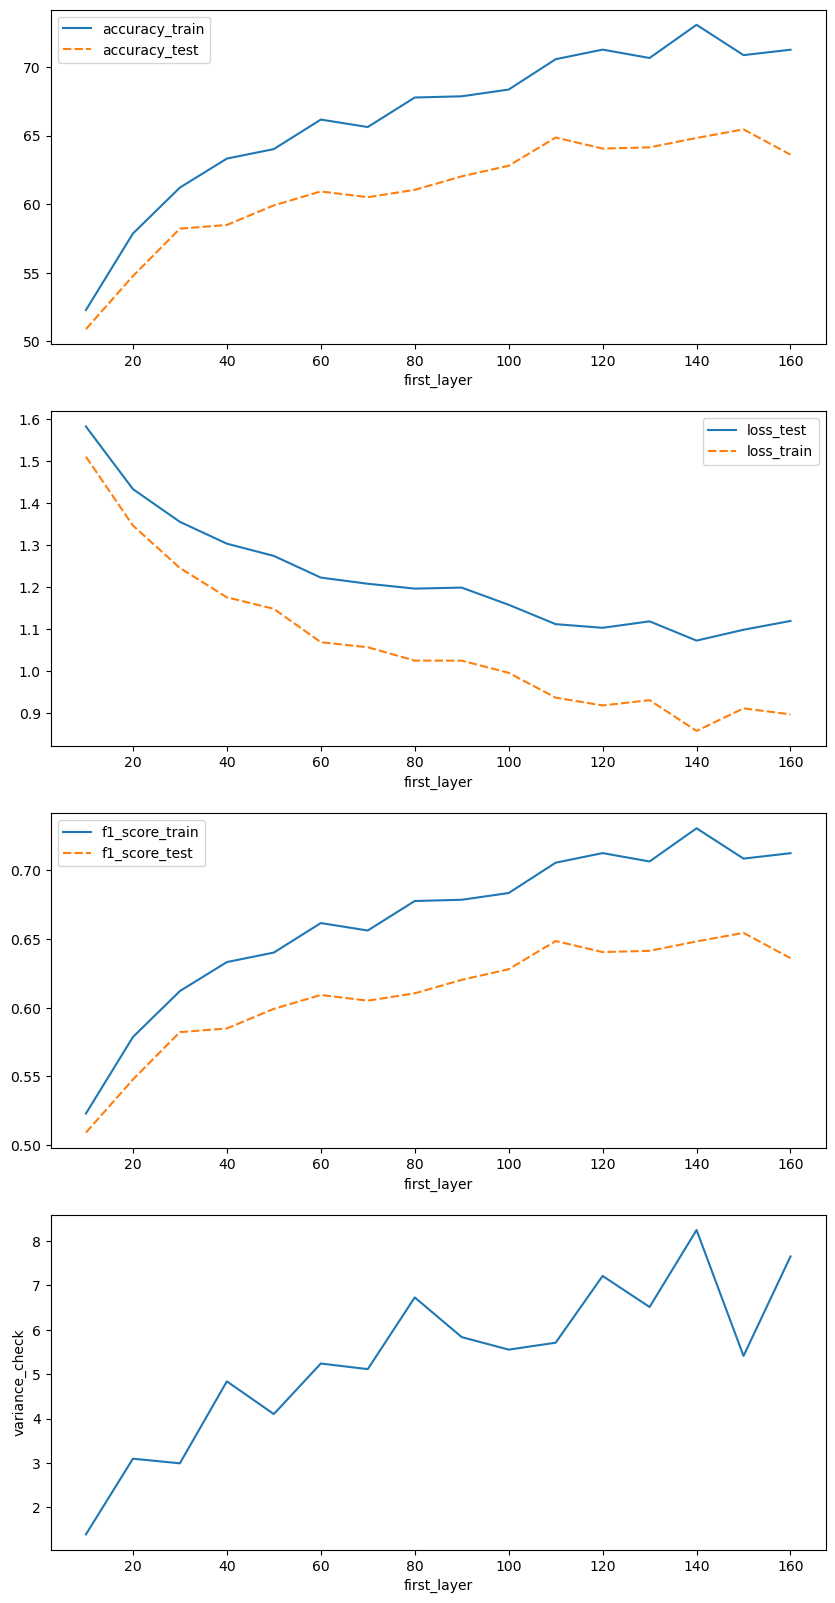

In [36]:
fig, axs = plt.subplots(4, figsize=(10,20))
sns.lineplot(data=parameters_inner[['accuracy_train', 'accuracy_test']], ax=axs[0])
sns.lineplot(data=parameters_inner[['loss_test', 'loss_train']], ax=axs[1])
sns.lineplot(data=parameters_inner[['f1_score_train', 'f1_score_test']], ax=axs[2])
sns.lineplot(data=parameters_inner['variance_check'], ax=axs[3])


Looking at the graphs, it seems the most rapid change seems to happen until the layer size resches 60-70, and then the gains in accuracy/f1_score start decreasing, so I will select this as the initial layer size. Next we want to investigate if the last layer i.e. the layer that produces the final output.

In [38]:
parameters_4={'loss_train':[], 'accuracy_train':[], 'f1_score_train':[],'loss_test':[], 'accuracy_test':[], 'f1_score_test':[], 'variance_check':[],'last_layer':[]}
k=0
for layer in layer_size:
    print(layer)
    tr_metric, ts_metric = SingleTrain_tails(nodes_inner=60, nodes_outer=layer, num_epochs=100, learning_rate = 0.001,printing = True)
    parameters_4['loss_train'].append(tr_metric['loss'][-1])
    parameters_4['loss_test'].append(ts_metric['loss'][-1])
    parameters_4['accuracy_train'].append(tr_metric['accuracy'][-1])
    parameters_4['accuracy_test'].append(ts_metric['accuracy'][-1])
    parameters_4['f1_score_train'].append(tr_metric['f1_score'][-1])
    parameters_4['f1_score_test'].append(ts_metric['f1_score'][-1])
    parameters_4['variance_check'].append(tr_metric['accuracy'][-1]-ts_metric['accuracy'][-1])
    parameters_4['last_layer'].append(layer)
    k+=1
    print(f'{k} down, {len(layer_size)-k} to go')
    print('------------------------')

10
Epoch: 0 | Train loss: 3.62764 | Train accuracy: 3.780% | Train f1 0.038 | Test accuracy 3.571% | Test f1 0.036
Epoch: 10 | Train loss: 3.32481 | Train accuracy: 6.711% | Train f1 0.067 | Test accuracy 7.917% | Test f1 0.079
Epoch: 20 | Train loss: 3.28224 | Train accuracy: 9.420% | Train f1 0.094 | Test accuracy 9.970% | Test f1 0.100
Epoch: 30 | Train loss: 3.21089 | Train accuracy: 9.382% | Train f1 0.094 | Test accuracy 9.286% | Test f1 0.093
Epoch: 40 | Train loss: 3.11912 | Train accuracy: 12.083% | Train f1 0.121 | Test accuracy 11.548% | Test f1 0.115
Epoch: 50 | Train loss: 3.00335 | Train accuracy: 15.484% | Train f1 0.155 | Test accuracy 14.494% | Test f1 0.145
Epoch: 60 | Train loss: 2.86700 | Train accuracy: 18.110% | Train f1 0.181 | Test accuracy 17.798% | Test f1 0.178
Epoch: 70 | Train loss: 2.71126 | Train accuracy: 21.518% | Train f1 0.215 | Test accuracy 21.280% | Test f1 0.213
Epoch: 80 | Train loss: 2.53132 | Train accuracy: 26.585% | Train f1 0.266 | Test accu

In [40]:
parameters_outer=pd.DataFrame(parameters_4).set_index('last_layer')

<Axes: xlabel='last_layer', ylabel='variance_check'>

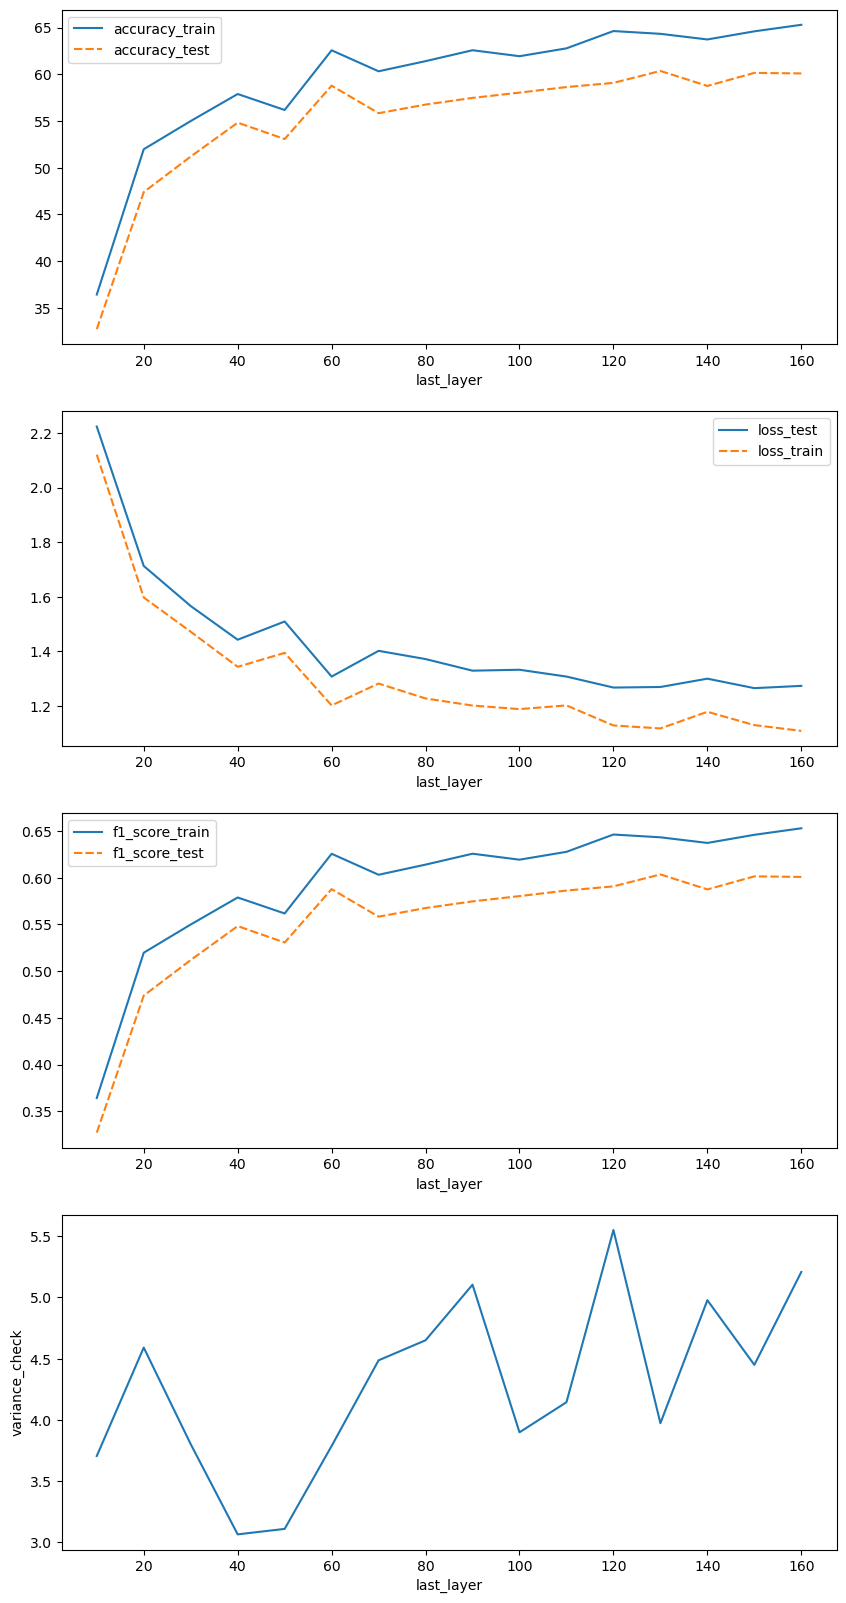

In [41]:
fig, axs = plt.subplots(4, figsize=(10,20))
sns.lineplot(data=parameters_outer[['accuracy_train', 'accuracy_test']], ax=axs[0])
sns.lineplot(data=parameters_outer[['loss_test', 'loss_train']], ax=axs[1])
sns.lineplot(data=parameters_outer[['f1_score_train', 'f1_score_test']], ax=axs[2])
sns.lineplot(data=parameters_outer['variance_check'], ax=axs[3])

As we can see 60-70 seems to be the magic number again. Last thing we want to check, are some more advanced options such as checking how dropout changes the results, as well as adding rgularization to minimize overfitting.

In [42]:
class TestingDropout(nn.Module):
    def __init__(self, n_char, dropout, nodes_inner=60, nodes_outer=60):
        super().__init__()
        self.inner=nn.Linear(1024, nodes_inner)
        self.hidden1=nn.Linear(nodes_inner, 160)
        self.hidden2=nn.Linear(160,nodes_outer)
        self.outer=nn.Linear(nodes_outer, n_char)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(p=dropout)
        self.batch1=nn.BatchNorm1d(nodes_inner)
        self.batch2=nn.BatchNorm1d(160)
        self.batch3=nn.BatchNorm1d(nodes_outer)
        
    def forward(self, x):
        X = self.inner(x)
        X = self.relu(X)
        X = self.batch1(X)
        X = self.dropout(X)
        
        X = self.hidden1(X)
        X = self.relu(X)
        X = self.batch2(X)
        X = self.dropout(X)
        
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.batch3(X)
        X = self.dropout(X)
        
        
        X = self.outer(X)
        
        return X

In [43]:
model_drop=TestingDropout(28, 0.5)
model_drop

TestingDropout(
  (inner): Linear(in_features=1024, out_features=60, bias=True)
  (hidden1): Linear(in_features=60, out_features=160, bias=True)
  (hidden2): Linear(in_features=160, out_features=60, bias=True)
  (outer): Linear(in_features=60, out_features=28, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [47]:
def SingleTrain_drop(prob, num_epochs, learning_rate,printing = False, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, loss=nn.CrossEntropyLoss()):
    model=model_2=TestingDropout(n_char=28, dropout=prob).to(device)
    loss=loss
    optimization= optim.Adam(params=model.parameters(), lr=learning_rate)

    train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    for epoch in range(num_epochs):
    
        train_pred=model(train_data)
        model.train()
        
        y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
        
        optimization.zero_grad()
        
        loss_epoch = loss(train_pred, y_train)
        
        f1_train, acc_train = metrics(train_pred, y_train, 28)
        
        loss_epoch.backward()
        
        optimization.step()
        
        train_metrics['loss'].append(loss_epoch.item())
        train_metrics['accuracy'].append(acc_train.item()*100)
        train_metrics['f1_score'].append(f1_train.item())
    
        model.eval()
        with torch.inference_mode():
            test_pred = model(test_data)
            y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
            loss_eval=loss(test_pred, y_eval)
            f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
            
            test_metrics['accuracy'].append(acc_test.item()*100)
            test_metrics['f1_score'].append(f1_test.item())
            test_metrics['loss'].append(loss_eval.item())

        if printing:
            if epoch%10==0:
                print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
            

    return train_metrics, test_metrics

    

In [63]:
drop_rates=np.arange(0, 1, 0.1)
drop_extended=[]
for i in range(15):
    drop_extended.extend(drop_rates)


In [64]:
parameters_5={'loss_train':[], 'accuracy_train':[], 'f1_score_train':[],'loss_test':[], 'accuracy_test':[], 'f1_score_test':[], 'variance_check':[],'drop_prob':[]}
k=0
for prob in drop_extended:
    print(prob)
    tr_metric, ts_metric = SingleTrain_drop(prob=prob, num_epochs=100, learning_rate = 0.001,printing = True)
    parameters_5['loss_train'].append(tr_metric['loss'][-1])
    parameters_5['loss_test'].append(ts_metric['loss'][-1])
    parameters_5['accuracy_train'].append(tr_metric['accuracy'][-1])
    parameters_5['accuracy_test'].append(ts_metric['accuracy'][-1])
    parameters_5['f1_score_train'].append(tr_metric['f1_score'][-1])
    parameters_5['f1_score_test'].append(ts_metric['f1_score'][-1])
    parameters_5['variance_check'].append(tr_metric['accuracy'][-1]-ts_metric['accuracy'][-1])
    parameters_5['drop_prob'].append(prob)
    k+=1
    print(f'{k} down, {len(drop_extended)-k} to go')
    print('------------------------')

0.0
Epoch: 0 | Train loss: 3.47550 | Train accuracy: 4.449% | Train f1 0.044 | Test accuracy 3.720% | Test f1 0.037
Epoch: 10 | Train loss: 3.30623 | Train accuracy: 6.972% | Train f1 0.070 | Test accuracy 7.679% | Test f1 0.077
Epoch: 20 | Train loss: 3.20963 | Train accuracy: 11.622% | Train f1 0.116 | Test accuracy 10.982% | Test f1 0.110
Epoch: 30 | Train loss: 2.92447 | Train accuracy: 12.195% | Train f1 0.122 | Test accuracy 12.887% | Test f1 0.129
Epoch: 40 | Train loss: 2.60726 | Train accuracy: 20.818% | Train f1 0.208 | Test accuracy 21.161% | Test f1 0.212
Epoch: 50 | Train loss: 2.34870 | Train accuracy: 30.603% | Train f1 0.306 | Test accuracy 30.893% | Test f1 0.309
Epoch: 60 | Train loss: 2.13778 | Train accuracy: 36.734% | Train f1 0.367 | Test accuracy 35.655% | Test f1 0.357
Epoch: 70 | Train loss: 1.94250 | Train accuracy: 42.917% | Train f1 0.429 | Test accuracy 41.399% | Test f1 0.414
Epoch: 80 | Train loss: 1.75772 | Train accuracy: 48.073% | Train f1 0.481 | Test

In [68]:
parameters_drop=pd.DataFrame(parameters_5)
grouped_drop=parameters_drop.groupby('drop_prob').mean()

<Axes: xlabel='drop_prob', ylabel='variance_check'>

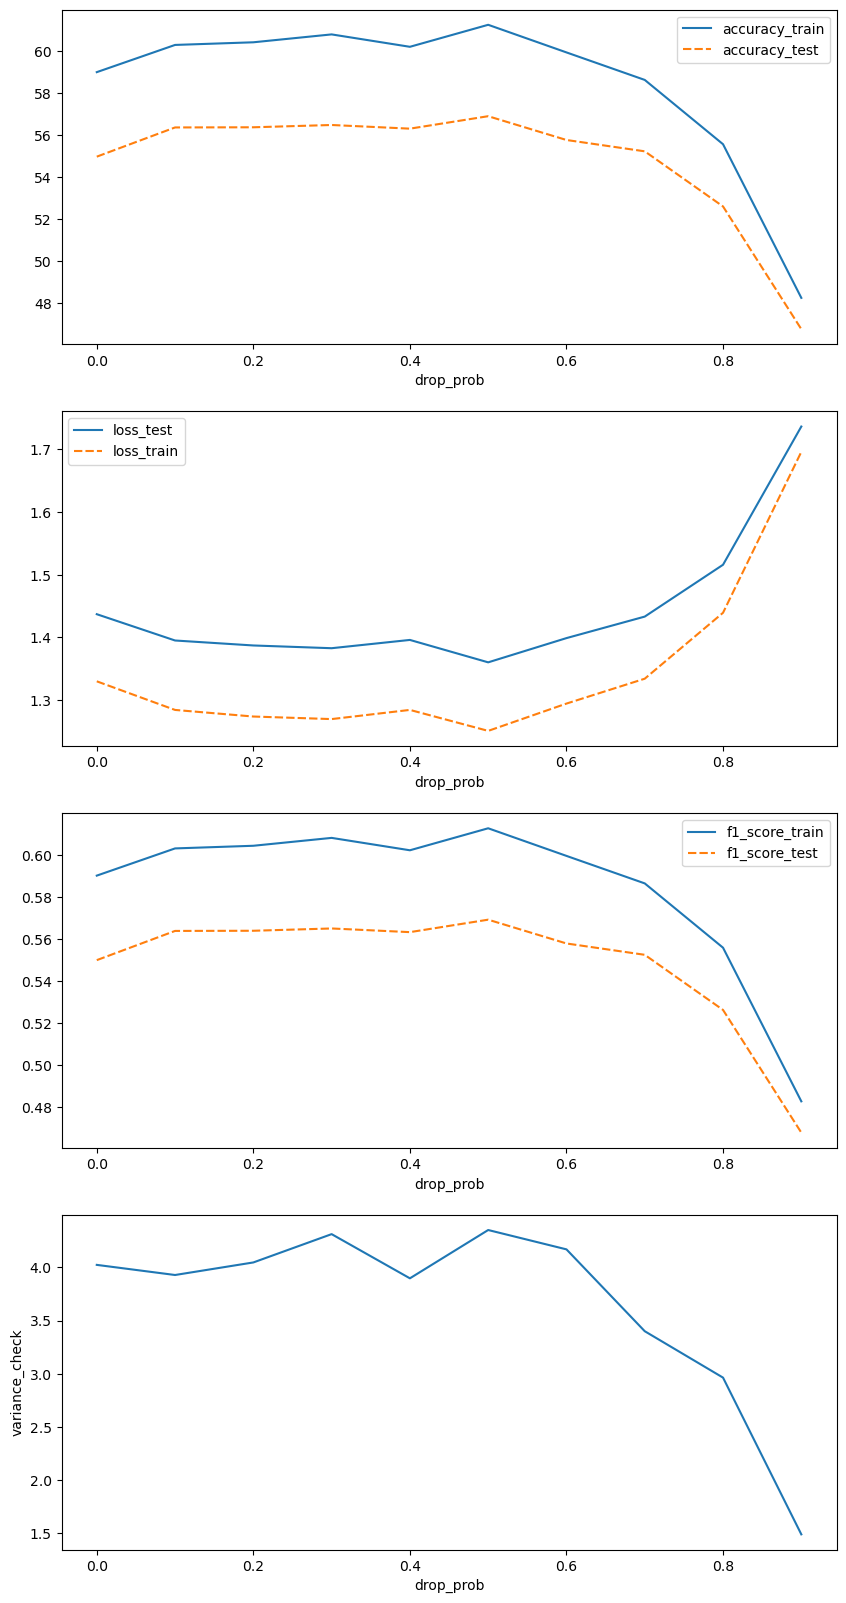

In [69]:
fig, axs = plt.subplots(4, figsize=(10,20))
sns.lineplot(data=grouped_drop[['accuracy_train', 'accuracy_test']], ax=axs[0])
sns.lineplot(data=grouped_drop[['loss_test', 'loss_train']], ax=axs[1])
sns.lineplot(data=grouped_drop[['f1_score_train', 'f1_score_test']], ax=axs[2])
sns.lineplot(data=grouped_drop['variance_check'], ax=axs[3])

It's fairly clear from the results that the choice of dropout makes little difference until it reaches 0.5, after which most parameters change in undesirable ways, so I will stick with 